# Fake Profile Proxy Dataset

In this notebook, we train a series of models to classify of a profile is fradulent (scammer) on dating applications.

For fradulent profiles on dating applications, our group was unable to find a real dataset specific to our domain. To remedy, we used a dataset consisting of real and fake profiles from Instagram. This dataset is publically available on Kaggle and contains profile metadata such as the number of followers, number of posts, and the number of people the user is following. The dataset also contains a binary label indicating whether the profile is real or fake. Using this as a starting point, we create a synthetic dataset of fake dating profiles by dropping irrelevant columns and adding new fields that are relevant to our domain.

### Set Up

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from ctgan import CTGAN
from table_evaluator import load_data, TableEvaluator

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
!pip install ctgan
!pip install table_evaluator
!pip install kaggle

In [8]:
!kaggle datasets download -d free4ever1/instagram-fake-spammer-genuine-accounts
!unzip instagram-fake-spammer-genuine-accounts.zip

Dataset URL: https://www.kaggle.com/datasets/free4ever1/instagram-fake-spammer-genuine-accounts
License(s): Attribution 3.0 Unported (CC BY 3.0)
  0%|                                               | 0.00/6.81k [00:00<?, ?B/s]
100%|██████████████████████████████████████| 6.81k/6.81k [00:00<00:00, 3.14MB/s]
Archive:  instagram-fake-spammer-genuine-accounts.zip
  inflating: test.csv                
  inflating: train.csv               


In [9]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

### Data Preprocessing

For our data preprocessing steps, we drop columns that are irrelevant to the dating app domain. We also change the names of columns from the original csv file to address some Python syntax errors that would arise. Since we are using a proxy dataset, there are certain columns that may be relevant to our domain, but they have rows with values that are not feasible. In this particular case, we noticed that number of posts for certain profiles we considerably high (30+). Because of this, we drop rows with values above this threshold. All of these steps are handled in the `preprocess_data` function below.

In [11]:

def preprocess_data(data):
  columns_to_rename = {'#posts': 'num_posts'}
  data.rename(columns=columns_to_rename, inplace=True)
  
  cols_to_drop = ['profile pic', '#followers', '#follows', 'private']
  data.drop(columns=cols_to_drop, inplace=True)
  
  high_photo_count_index_train = data[data.num_posts < 31].index
  data.drop(high_photo_count_index_train, inplace=True)
  
  return data

With our training and test data cleaned up, we can see how many data points we are working with. After dropping rows with high number of posts, we are left with roughly a 90% train 10% test split.

In [12]:
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

print(f'training data size: {train_data.size}')
print(f'training data size: {test_data.size}')

training data size: 1712
training data size: 296


### Synthetic Column Generation

With our cleaned dataset, we can now generate synthetic columns that are relevant to the dating app domain. In this step, we generate synthetic columns with sampled data based on specific distribution parameters. The `add_normal_column` function creates a new column in the dataset where each value is determined by whether an entry is flagged as fake, using different mean values for 'spam' and 'non-spam' scenarios, adjusted by random noise. The `add_normal_columns` function applies this to multiple columns as specified. The `add_gender_column` function assigns a binary gender based on a defined probability, simulating the male-female ratio. The `add_gendered_column` function further adds complexity by generating values from a range that varies based not only on the 'fake' flag but also on the gender, allowing for nuanced simulations like response rates or initial message lengths. By conditionally applying these functions to both training and testing data subsets, we can produce realistic variations and behaviors observed in actual user data on dating platforms.

We based our decisions for distribution parameters based on the following sources:

- **Tinder Usage Statistics**: Provides general statistics on Tinder usage. [View Source](https://www.enterpriseappstoday.com/stats/tinder-statistics.html)
- **Tinder User Engagement Stats**: Discusses user engagement statistics on Tinder. [View Source](https://roast.dating/blog/tinder-statistics)
- **Tinder Video Selfie Verification Analysis**: An analysis of Tinder’s video selfie verification feature. [View Source](https://roast.dating/blog/tinder-video-selfie-verification)
- **Humor in Tinder Dating**: Discusses the role of humor in Tinder interactions and response rates. [View Source](https://irrationallabs.com/blog/tinder-humor-dating/#:~:text=Men%20may%20still%20have%20the,back%2021%25%20of%20the%20time)
- **Men's Age Range Preferences on Tinder**: An article on how men set their age preferences on Tinder. [View Source](https://www.bustle.com/articles/138190-heres-what-men-set-their-age-range-to-on-tinder)

In [4]:
def add_normal_column(data, column_name, spam_mean, non_spam_mean, std_dev=3, epsilon=3, fake_column='fake'):
    def generate_values(row):
        if row[fake_column] == 1:
            noise = np.random.normal(0, std_dev)
            return np.round(np.random.normal(spam_mean, std_dev) + epsilon * noise, 2)
        else:
            noise = np.random.normal(0, std_dev)
            return np.round(np.random.normal(non_spam_mean, std_dev) + epsilon * noise, 2)

    data[column_name] = data.apply(generate_values, axis=1)
    return data

def add_normal_columns(data, columns):
    for column in columns:
        column_name, spam_value, non_spam_value = column
        data = add_normal_column(data, column_name, spam_value, non_spam_value)
    return data

def add_gender_column(data, male_probability=0.75):
    column_values = np.random.choice([1, 0], size=len(data), p=[male_probability, 1 - male_probability]).astype(int)
    data['gender'] = column_values
    return data

def add_gendered_column(data, column_name, scam_range, non_scam_male_range, non_scam_female_range, fake_column='fake'):
    def generate_values(row):
        if row[fake_column] == 1:
            return np.random.uniform(*scam_range)
        else:
            if row['gender'] == 'Male':
                return np.round(np.random.uniform(*non_scam_male_range), 2)
            else:
                return np.round(np.random.uniform(*non_scam_female_range), 2)

    data[column_name] = data.apply(generate_values, axis=1)
    return data

In [5]:
def add_columns(data):
    data = add_gender_column(data)
    columns = [('time_spent', 50, 35), ('daily_activity', 70, 56)]
    data = add_normal_columns(data, columns)
    data = add_gendered_column(data, 'response_rate', (0.8, 1.0), (0.63, 1.0), (0.18, 1.0))
    data = add_gendered_column(data, 'first_message', (0.8, 1.0), (0.63, 1.0), (0.18, 1.0))
    return data

add_new_columns = False
if add_new_columns:
  train_data = add_columns(train_data)
  test_data = add_columns(test_data)

print(train_data.head())

   nums/length username  fullname words  nums/length fullname  name==username  \
0                  0.27               0                   0.0               0   
1                  0.00               2                   0.0               0   
3                  0.00               1                   0.0               0   
5                  0.00               4                   0.0               0   
7                  0.00               2                   0.0               0   

   description length  external URL  num_posts  fake  
0                  53             0         32     0  
1                  44             0        286     0  
3                  82             0        679     0  
5                  81             1        344     0  
7                   0             0         33     0  


### Data Generation with CTGAN

Now, we use a conditional generative adversarial network (CTGAN) to generate more data points. First, specific features such as 'name==username', 'external URL', and 'fake' are designated as categorical variables. The CTGAN model is then trained on a dataset (`train_data`) for 300 epochs. After training, the model generates 1000 synthetic samples.

In [8]:
categorical_features = ['name==username', 'external URL', 'fake'] # 'profile pic', 'private'
ctgan = CTGAN(verbose=True)
ctgan.fit(train_data, categorical_features, epochs = 300)

Gen. (-1.48) | Discrim. (-0.04): 100%|██████████| 300/300 [00:37<00:00,  8.03it/s]


In [ ]:
NUM_SAMPLES = 1000
synthetic_data = ctgan.sample(NUM_SAMPLES)

After training and sampling from the CTGAN model, we can see a comparison of the synthetic data points and our original dataset.

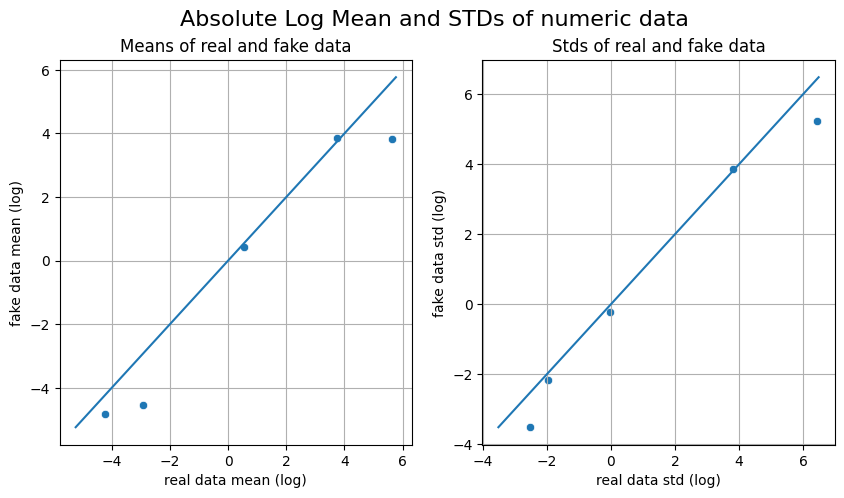

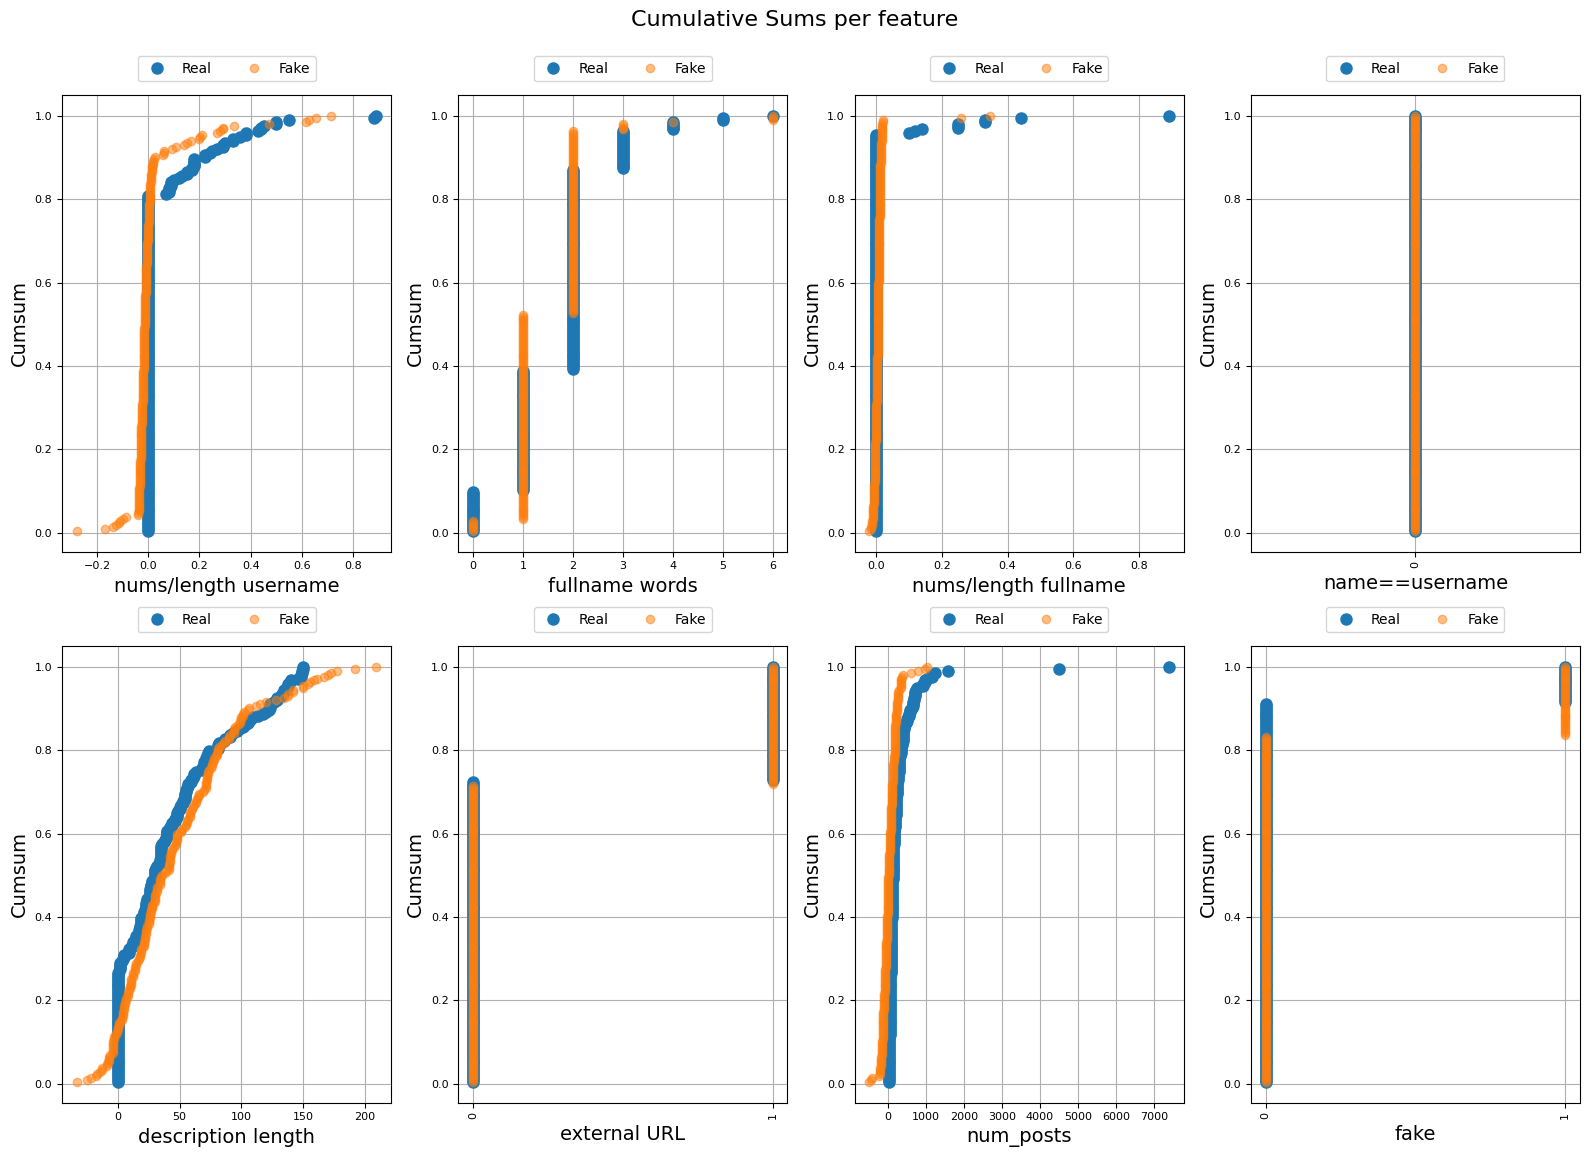

/usr/local/lib/python3.10/dist-packages/table_evaluator/table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
/usr/local/lib/python3.10/dist-packages/table_evaluator/table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')
/usr/local/lib/python3.10/dist-packages/table_evaluator/table_evaluator.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(axes[i].get_xticklabels(), rotation='vertical')


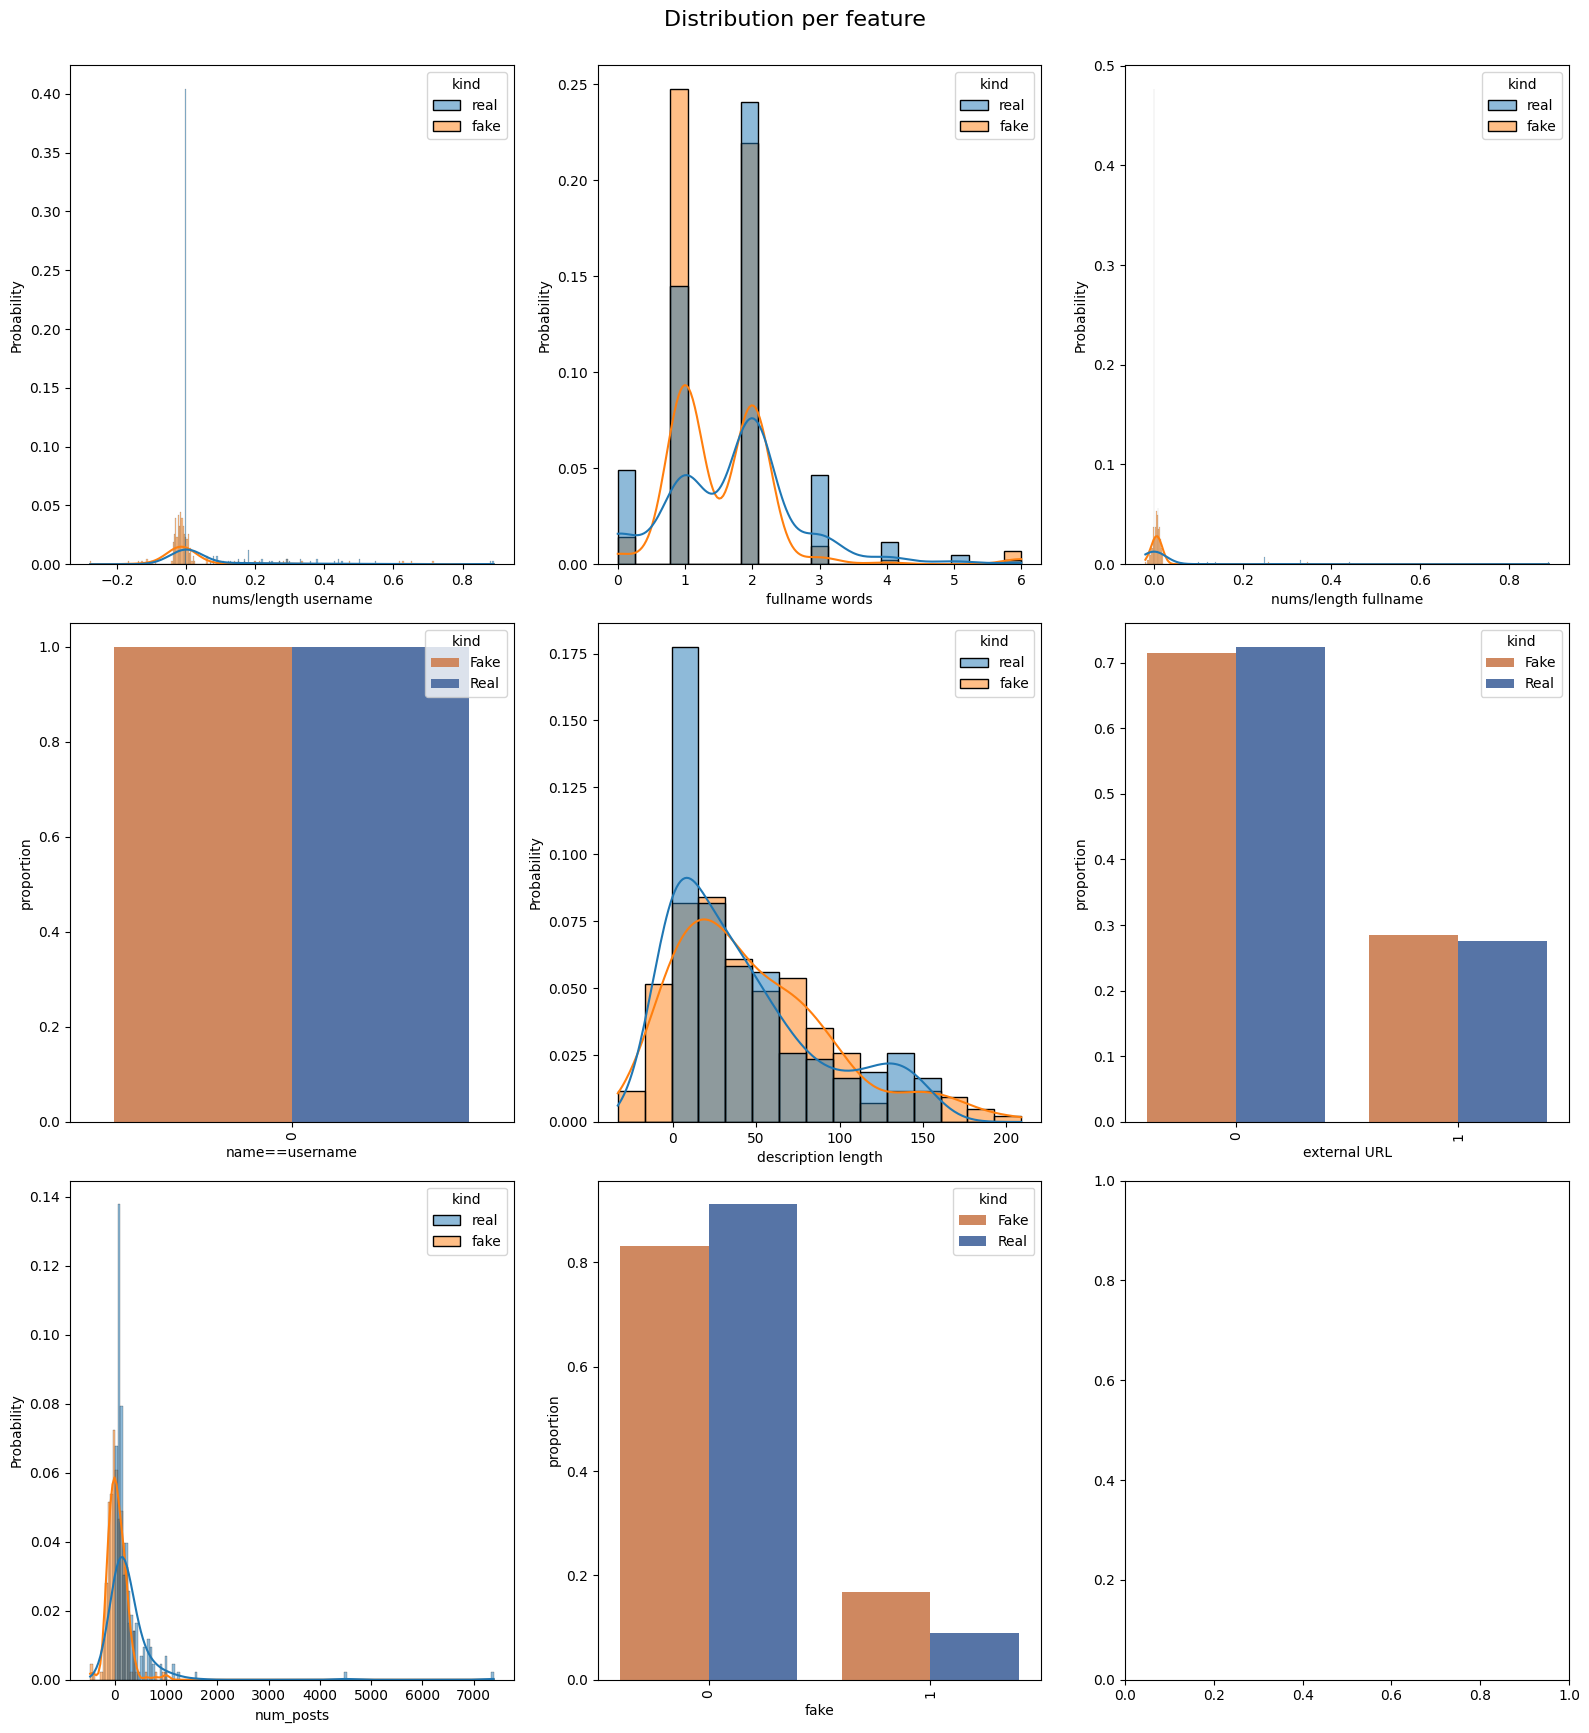

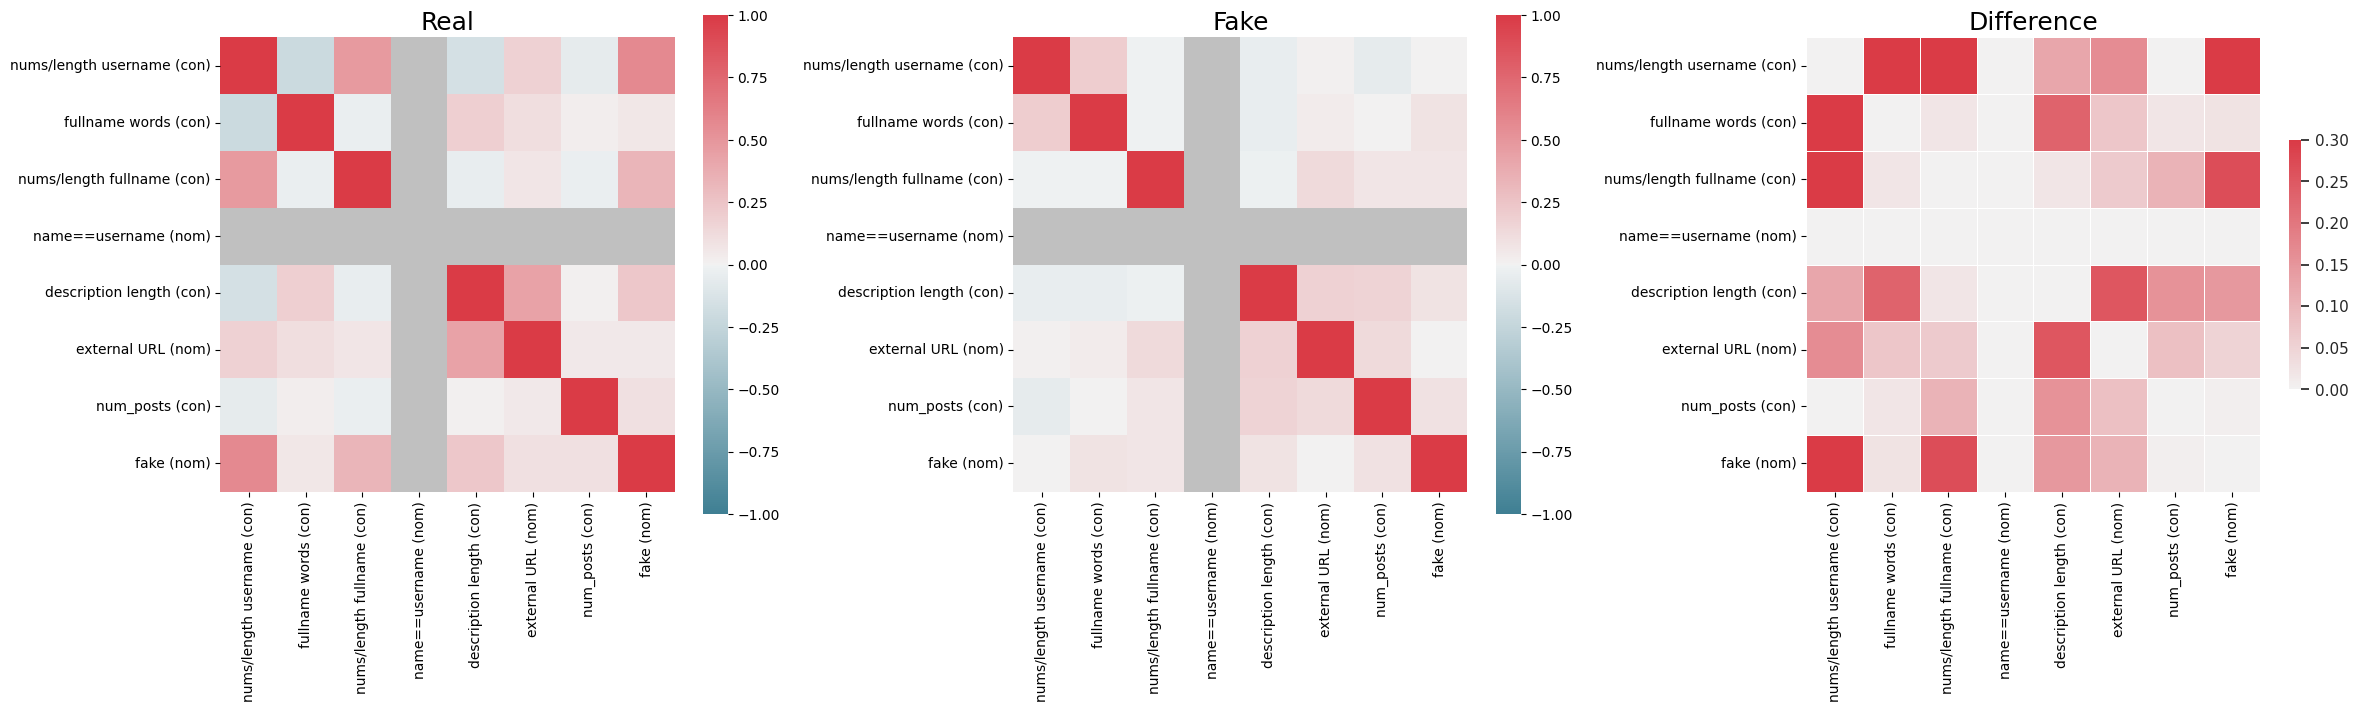

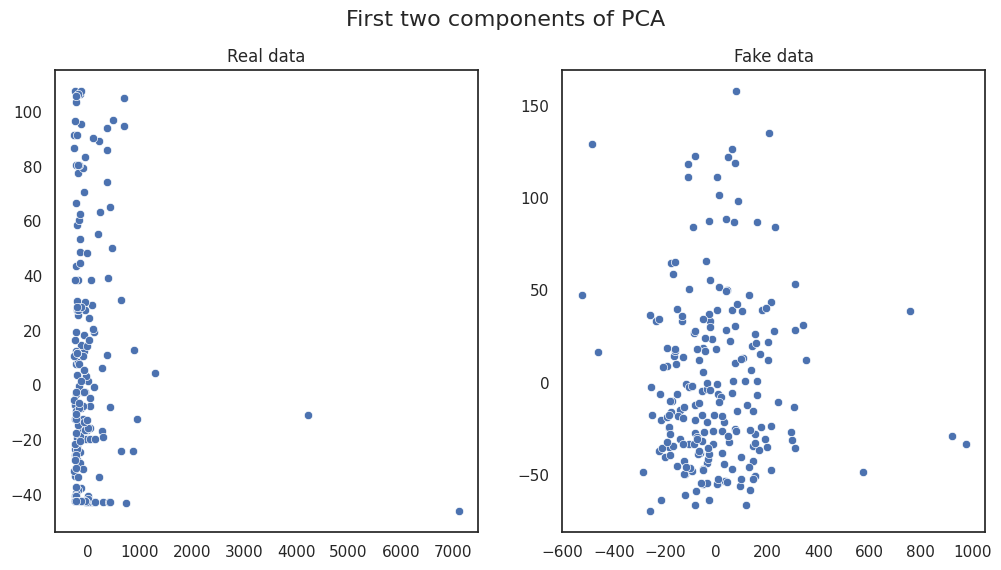

In [10]:
table_evaluator = TableEvaluator(train_data, synthetic_data, cat_cols= categorical_features)
table_evaluator.visual_evaluation()

Next, we concatenate our real and synthetic data points to create a final training dataset for our classification models.

In [11]:
train_data_aug = pd.concat([train_data, synthetic_data], ignore_index=True)

print(f'Augmented training data size: {train_data_aug.size}')
print(f'Training data size: {train_data.size}')
print(f'Synthetic data size: {synthetic_data.size}')
print(f'Test data size: {test_data.size}')

training data size: 9712
training data size: 1712
training data size: 8000
training data size: 296


,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,num_posts,fake
0,0.27,0,0.0,0,53,0,32,0
1,0.00,2,0.0,0,44,0,286,0
2,0.00,1,0.0,0,82,0,679,0
3,0.00,4,0.0,0,81,1,344,0
4,0.00,2,0.0,0,0,0,33,0


### Data Normalization for Non-Tree Based Models

Lastly, we will make normalized versions of the dataset for our logistic regression classifier.

In [12]:
train_data_scaled = train_data.copy()
test_data_scaled = test_data.copy()
train_data_aug_scaled = train_data_aug.copy()

# Select features to scale (excluding binary features and small range integers)
features_to_scale = ['nums/length username', 'fullname words', 'nums/length fullname',
                     'description length', 'num_posts']

scaler = StandardScaler()

# Fit on training data only (prevent any data leakage)
scaler.fit(train_data[features_to_scale])
# scaler.fit(train_data_aug[features_to_scale])

# Transform both train and test data with the same scaler
train_data_scaled[features_to_scale] = scaler.transform(train_data[features_to_scale])
test_data_scaled[features_to_scale] = scaler.transform(test_data[features_to_scale])
train_data_aug_scaled[features_to_scale] = scaler.transform(train_data_aug[features_to_scale])


### Model Training and Evaluation

For our modeling, we use two different types of architectures: a logistic regression and a random forest classifier. We train both models on the original and synthetic datasets and evaluate their performance using accuracy, precision, recall, and F1 score.

In [13]:
# Separate the labels
train_labels = train_data['fake']
test_labels = test_data['fake']
aug_labels = train_data_aug['fake']

# Drop the 'fake' column from datasets
train_data.drop('fake', axis=1, inplace=True)
train_data_aug.drop('fake', axis=1, inplace=True)
test_data.drop('fake', axis=1, inplace=True)

train_data_scaled.drop('fake', axis=1, inplace=True)
train_data_aug_scaled.drop('fake', axis=1, inplace=True)
test_data_scaled.drop('fake', axis=1, inplace=True)

#### Random Forest Classifier

In [ ]:
def train_and_evaluate_rf(train_data, train_labels, test_data, test_labels):
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_classifier.fit(train_data, train_labels)
    rf_predictions = rf_classifier.predict(test_data)
    rf_probabilities = rf_classifier.predict_proba(train_data)[:, 1]  # Probability of label 1
    rf_accuracy = accuracy_score(test_labels, rf_predictions)
    rf_classification_report = classification_report(test_labels, rf_predictions)

    return rf_classifier, rf_predictions, rf_probabilities, rf_accuracy, rf_classification_report

In [22]:
# Assuming train_data, train_labels, train_data_aug, aug_labels, test_data, and test_labels are defined
print(f'Training data size: {train_data.size}')
print(f'Training data size (augmented): {train_data_aug.size}')

# Evaluate on train_data
rf_model, rf_predictions, rf_probabilities, rf_accuracy, rf_report = train_and_evaluate_rf(train_data, train_labels, test_data, test_labels)
print("Random Forest Accuracy on original training data:", rf_accuracy)
print("Random Forest Classification Report on original training data:\n", rf_report)

# Evaluate on train_data_aug
rf_model_aug, rf_predictions_aug, rf_probabilities_aug, rf_accuracy_aug, rf_report_aug = train_and_evaluate_rf(train_data_aug, aug_labels, test_data, test_labels)
print("Random Forest Accuracy on augmented training data:", rf_accuracy_aug)
print("Random Forest Classification Report on augmented training data:\n", rf_report_aug)

Training data size: 1498
Training data size (augmented): 8498
Random Forest Accuracy on original training data: 1.0
Random Forest Classification Report on original training data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00         4

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37

Random Forest Accuracy on augmented training data: 1.0
Random Forest Classification Report on augmented training data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00         4

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



#### Logistic Regression Classifier

In [ ]:
def train_and_evaluate_log_reg(train_data, train_labels, test_data, test_labels):
    log_reg = LogisticRegression(max_iter=1000, random_state=42)
    log_reg.fit(train_data, train_labels)
    log_reg_predictions = log_reg.predict(test_data)
    log_reg_accuracy = accuracy_score(test_labels, log_reg_predictions)
    log_reg_classification_report = classification_report(test_labels, log_reg_predictions)

    return log_reg, log_reg_predictions, log_reg_accuracy, log_reg_classification_report

In [ ]:
# Assuming train_data_scaled, train_labels, train_data_aug_scaled, test_data_scaled, and test_labels are defined
print(f'Training data size (scaled): {train_data_scaled.size}')
print(f'Training data size (augmented and scaled): {train_data_aug_scaled.size}')

# Evaluate on scaled train_data
log_reg_model, log_reg_predictions, log_reg_accuracy, log_reg_report = train_and_evaluate_log_reg(train_data_scaled, train_labels, test_data_scaled, test_labels)
print("Logistic Regression Accuracy on scaled training data:", log_reg_accuracy)
print("Logistic Regression Classification Report on scaled training data:\n", log_reg_report)

# Evaluate on scaled train_data_aug
log_reg_model_aug, log_reg_predictions_aug, log_reg_accuracy_aug, log_reg_report_aug = train_and_evaluate_log_reg(train_data_aug_scaled, aug_labels, test_data_scaled, test_labels)
print("Logistic Regression Accuracy on augmented and scaled training data:", log_reg_accuracy_aug)
print("Logistic Regression Classification Report on augmented and scaled training data:\n", log_reg_report_aug)

Training data size (scaled): 1498
Training data size (augmented and scaled): 8498
Logistic Regression Accuracy on scaled training data: 0.9459459459459459
Logistic Regression Classification Report on scaled training data:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97        33
           1       0.75      0.75      0.75         4

    accuracy                           0.95        37
   macro avg       0.86      0.86      0.86        37
weighted avg       0.95      0.95      0.95        37

Logistic Regression Accuracy on augmented and scaled training data: 0.8918918918918919
Logistic Regression Classification Report on augmented and scaled training data:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94        33
           1       0.00      0.00      0.00         4

    accuracy                           0.89        37
   macro avg       0.45      0.50      0.47        37
weighted 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Offline Evaluation Example

In [ ]:
train_data_with_probabilities = pd.DataFrame(train_data)
train_data_with_probabilities['probability_scammer'] = rf_probabilities
filtered_data = train_data_with_probabilities[train_data_with_probabilities['probability_scammer'] > 0.4]
sampled_data = filtered_data.sample(n=4, random_state=11)

# List of names to be added
names = ["gcbel", "gricci5913", "Ari G", "Larsen"]
sampled_data['name'] = names
sampled_data